In [ ]:
"""
Pattern Recognition and Machine Learning
Programming Exercise: 01
Name: Vo Thi Khanh Linh
Student ID: 21280070
"""

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [3]:
from sklearn.model_selection import train_test_split

#Dataset: CIFAR-10 & Data Augmentation


Em lựa chọn dataset CIFAR-10 vì em đánh giá độ khó của bộ dataset này là tầm trung. MNIST dễ đạt được acc cao nên độ hiểu quả của các cải tiến có thể không rõ ràng.

In [19]:
# Hyperparameters
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 20

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Tập Train có transform được thêm kỹ thuật data augmentation.

In [30]:
transform_train = transforms.Compose(
    [#transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(10),
     transforms.ColorJitter(hue=.05, saturation=.05),
     #transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

Tập Validation được chia từ dataset train với tỷ lệ 15%

In [31]:
# Download CIFAR10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainset, validset = train_test_split(trainset, test_size=0.15, random_state=1)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [20]:
print("Trainning set: ", len(trainset))
print("Validation set: ", len(validset))
print("Testing set: ", len(testset))

Trainning set:  42500
Validation set:  7500
Testing set:  10000


In [21]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In một vài tấm ảnh từ train set

Image size:  torch.Size([64, 3, 32, 32])
Label size:  torch.Size([64])


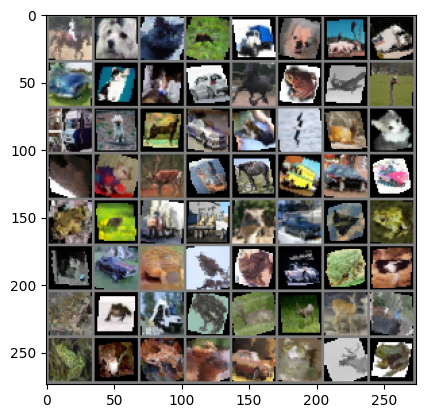

In [22]:
# get some random training images
images, labels = next(iter(trainloader))

print("Image size: ", images.shape ) # (batch_size, n_channels, height, width)
print("Label size: ", labels.shape)  # (batch_size, )


# show images
imshow(torchvision.utils.make_grid(images))

#Model

In [53]:
class ConvNeuralNet(nn.Module):
    def __init__(self, trial, in_channels=3, num_classes=10, drop_fc1 = .2):
        super(ConvNeuralNet, self).__init__()
        # Model được chia thành 2 module: feature extraction gồm các lớp Conv, Pool và classifier gồm các lớp FC
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.BatchNorm2d(32),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.BatchNorm2d(64)
        )
        # input -> 2x(conv2d -> ReLU) -> max_pool2d -> batch_norm -> 2x(conv2d -> ReLU) -> max_pool2d -> batch_norm -> (64, 64, 5, 5) -> (64, 64*5*5)

        self.classifier = nn.Sequential(
            nn.Dropout(drop_fc1),
            nn.Linear(1600, 128) ,
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        out = self.features(x)
        # print(out.shape)
        out = out.reshape(out.size(0), -1)
        out = self.classifier(out)
        return out

#Setting

In [34]:
model = ConvNeuralNet(in_channels=3, num_classes=10)

# Set Loss function
loss_fn = nn.CrossEntropyLoss()

# Set optimizer with optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(trainloader)

In [35]:
model.to(device)

ConvNeuralNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=1600, out_features=128, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

#Training and Validation

In [32]:
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []
#Các list này được tạo ra để lưu các thông số phục vụ cho việc vẽ hình

In [36]:
from tqdm import tqdm
for epoch in range(num_epochs):

    overall_loss = 0.0; correct = 0; total = 0
    model.train() # Active training mode of model, DO NOT forget this line

    for images, labels in (pbar:=tqdm(trainloader, desc=f'Epoch [{epoch+1}/{num_epochs}]')):
        # Transfer data to device (GPU/CPU)
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        overall_loss += loss.item()

        # Compute accuracy
        preds = torch.argmax(outputs.data, dim=1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

        # Progress bar logging
        pbar.set_postfix(loss=loss.item(), accuracy=correct/total)

        # Backward and optimize
        optimizer.zero_grad()   # Clear gradient cache of the previous step iteration
        loss.backward()
        optimizer.step()

    print('\tSummary epoch {}: Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch+1,
                                                                      overall_loss/total_step,
                                                                      correct/total))
    train_loss.append(overall_loss/total_step)
    train_acc.append(correct/total)
    model.eval() # Active evaluation mode
    total_val = 0; correct_val = 0; overall_val_loss = 0.0

    for inputs, labels in (pbar:=tqdm(validloader, desc="Validation")):
        with torch.no_grad(): # disable gradient computing
            # Transfer data to device (GPU/CPU)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = loss_fn(outputs, labels)
            overall_val_loss += loss.item()

            # Compute accuracy
            _, preds = torch.max(outputs.data, 1) # preds = torch.argmax(outputs.data, dim=1)
            total_val   += labels.size(0)
            correct_val += (preds == labels).sum().item()

            # Display
            pbar.set_postfix(loss=loss.item(), accuracy=correct_val/total_val)
            # print("Loss = ", loss.item())
            # print("Acc = ", correct_val/total_val)

    overall_val_loss /= len(testloader)
    print("(val) Epoch [{}/{}]: Loss={:.4f}, Accuracy={:.4f}".format(epoch+1, num_epochs, overall_val_loss, correct_val/total_val))
    valid_loss.append(overall_val_loss)
    valid_acc.append(correct_val/total_val)

Epoch [1/20]: 100%|██████████| 665/665 [02:24<00:00,  4.61it/s, accuracy=0.534, loss=2.25]


	Summary epoch 1: Loss: 1.2975, Accuracy: 0.5345


Validation: 100%|██████████| 118/118 [00:09<00:00, 12.25it/s, accuracy=0.642, loss=0.621]


(val) Epoch [1/20]: Loss=0.7605, Accuracy=0.6417


Epoch [2/20]: 100%|██████████| 665/665 [02:22<00:00,  4.68it/s, accuracy=0.668, loss=2.09]


	Summary epoch 2: Loss: 0.9431, Accuracy: 0.6678


Validation: 100%|██████████| 118/118 [00:10<00:00, 11.27it/s, accuracy=0.689, loss=0.581]


(val) Epoch [2/20]: Loss=0.6506, Accuracy=0.6895


Epoch [3/20]: 100%|██████████| 665/665 [02:22<00:00,  4.66it/s, accuracy=0.716, loss=1.7]


	Summary epoch 3: Loss: 0.8110, Accuracy: 0.7156


Validation: 100%|██████████| 118/118 [00:10<00:00, 10.80it/s, accuracy=0.683, loss=0.515]


(val) Epoch [3/20]: Loss=0.6865, Accuracy=0.6828


Epoch [4/20]: 100%|██████████| 665/665 [02:22<00:00,  4.68it/s, accuracy=0.731, loss=1]


	Summary epoch 4: Loss: 0.7678, Accuracy: 0.7308


Validation: 100%|██████████| 118/118 [00:10<00:00, 10.87it/s, accuracy=0.747, loss=0.371]


(val) Epoch [4/20]: Loss=0.5439, Accuracy=0.7468


Epoch [5/20]: 100%|██████████| 665/665 [02:21<00:00,  4.70it/s, accuracy=0.78, loss=0.923]


	Summary epoch 5: Loss: 0.6275, Accuracy: 0.7805


Validation: 100%|██████████| 118/118 [00:10<00:00, 10.94it/s, accuracy=0.752, loss=0.404]


(val) Epoch [5/20]: Loss=0.5364, Accuracy=0.7521


Epoch [6/20]: 100%|██████████| 665/665 [02:24<00:00,  4.62it/s, accuracy=0.802, loss=1.36]


	Summary epoch 6: Loss: 0.5630, Accuracy: 0.8025


Validation: 100%|██████████| 118/118 [00:10<00:00, 11.76it/s, accuracy=0.751, loss=0.338]


(val) Epoch [6/20]: Loss=0.5445, Accuracy=0.7508


Epoch [7/20]: 100%|██████████| 665/665 [02:26<00:00,  4.54it/s, accuracy=0.82, loss=2.23]


	Summary epoch 7: Loss: 0.5097, Accuracy: 0.8205


Validation: 100%|██████████| 118/118 [00:15<00:00,  7.39it/s, accuracy=0.748, loss=0.571]


(val) Epoch [7/20]: Loss=0.5519, Accuracy=0.7480


Epoch [8/20]: 100%|██████████| 665/665 [02:31<00:00,  4.39it/s, accuracy=0.842, loss=0.673]


	Summary epoch 8: Loss: 0.4487, Accuracy: 0.8424


Validation: 100%|██████████| 118/118 [00:10<00:00, 11.58it/s, accuracy=0.754, loss=0.497]


(val) Epoch [8/20]: Loss=0.5601, Accuracy=0.7541


Epoch [9/20]: 100%|██████████| 665/665 [02:20<00:00,  4.72it/s, accuracy=0.851, loss=1.12]


	Summary epoch 9: Loss: 0.4216, Accuracy: 0.8511


Validation: 100%|██████████| 118/118 [00:10<00:00, 11.30it/s, accuracy=0.759, loss=0.492]


(val) Epoch [9/20]: Loss=0.5503, Accuracy=0.7595


Epoch [10/20]: 100%|██████████| 665/665 [02:20<00:00,  4.74it/s, accuracy=0.874, loss=0.775]


	Summary epoch 10: Loss: 0.3599, Accuracy: 0.8743


Validation: 100%|██████████| 118/118 [00:10<00:00, 11.65it/s, accuracy=0.756, loss=0.67]


(val) Epoch [10/20]: Loss=0.5654, Accuracy=0.7556


Epoch [11/20]: 100%|██████████| 665/665 [02:23<00:00,  4.62it/s, accuracy=0.887, loss=1.03]


	Summary epoch 11: Loss: 0.3222, Accuracy: 0.8867


Validation: 100%|██████████| 118/118 [00:10<00:00, 11.12it/s, accuracy=0.762, loss=0.374]


(val) Epoch [11/20]: Loss=0.5820, Accuracy=0.7616


Epoch [12/20]: 100%|██████████| 665/665 [02:16<00:00,  4.86it/s, accuracy=0.893, loss=0.667]


	Summary epoch 12: Loss: 0.3022, Accuracy: 0.8932


Validation: 100%|██████████| 118/118 [00:09<00:00, 12.34it/s, accuracy=0.752, loss=0.663]


(val) Epoch [12/20]: Loss=0.6140, Accuracy=0.7524


Epoch [13/20]: 100%|██████████| 665/665 [02:19<00:00,  4.77it/s, accuracy=0.902, loss=1.6]


	Summary epoch 13: Loss: 0.2748, Accuracy: 0.9024


Validation: 100%|██████████| 118/118 [00:09<00:00, 12.91it/s, accuracy=0.749, loss=0.516]


(val) Epoch [13/20]: Loss=0.6320, Accuracy=0.7491


Epoch [14/20]: 100%|██████████| 665/665 [02:25<00:00,  4.56it/s, accuracy=0.904, loss=1.99]


	Summary epoch 14: Loss: 0.2771, Accuracy: 0.9036


Validation: 100%|██████████| 118/118 [00:10<00:00, 11.01it/s, accuracy=0.758, loss=0.935]


(val) Epoch [14/20]: Loss=0.6363, Accuracy=0.7580


Epoch [15/20]: 100%|██████████| 665/665 [02:20<00:00,  4.74it/s, accuracy=0.915, loss=0.121]


	Summary epoch 15: Loss: 0.2394, Accuracy: 0.9152


Validation: 100%|██████████| 118/118 [00:10<00:00, 10.74it/s, accuracy=0.763, loss=0.937]


(val) Epoch [15/20]: Loss=0.6396, Accuracy=0.7627


Epoch [16/20]: 100%|██████████| 665/665 [02:19<00:00,  4.78it/s, accuracy=0.927, loss=0.909]


	Summary epoch 16: Loss: 0.2089, Accuracy: 0.9270


Validation: 100%|██████████| 118/118 [00:11<00:00, 10.64it/s, accuracy=0.749, loss=0.973]


(val) Epoch [16/20]: Loss=0.6838, Accuracy=0.7493


Epoch [17/20]: 100%|██████████| 665/665 [02:21<00:00,  4.71it/s, accuracy=0.926, loss=1.83]


	Summary epoch 17: Loss: 0.2062, Accuracy: 0.9263


Validation: 100%|██████████| 118/118 [00:10<00:00, 11.19it/s, accuracy=0.76, loss=0.511]


(val) Epoch [17/20]: Loss=0.6546, Accuracy=0.7601


Epoch [18/20]: 100%|██████████| 665/665 [02:19<00:00,  4.75it/s, accuracy=0.931, loss=1.5]


	Summary epoch 18: Loss: 0.1948, Accuracy: 0.9315


Validation: 100%|██████████| 118/118 [00:10<00:00, 10.78it/s, accuracy=0.758, loss=0.472]


(val) Epoch [18/20]: Loss=0.6828, Accuracy=0.7577


Epoch [19/20]: 100%|██████████| 665/665 [02:18<00:00,  4.81it/s, accuracy=0.934, loss=1.12]


	Summary epoch 19: Loss: 0.1866, Accuracy: 0.9340


Validation: 100%|██████████| 118/118 [00:10<00:00, 11.15it/s, accuracy=0.753, loss=0.529]


(val) Epoch [19/20]: Loss=0.7045, Accuracy=0.7531


Epoch [20/20]: 100%|██████████| 665/665 [02:18<00:00,  4.81it/s, accuracy=0.942, loss=1.64]


	Summary epoch 20: Loss: 0.1700, Accuracy: 0.9420


Validation: 100%|██████████| 118/118 [00:09<00:00, 12.10it/s, accuracy=0.765, loss=0.985]

(val) Epoch [20/20]: Loss=0.6778, Accuracy=0.7645


Lưu lại tham số của model (check point)

In [37]:
PATH = './cifar_model.pth'
torch.save(model.state_dict(), PATH)

Trực quan hóa sự thay đổi của loss và acc trên 2 tập train và validation

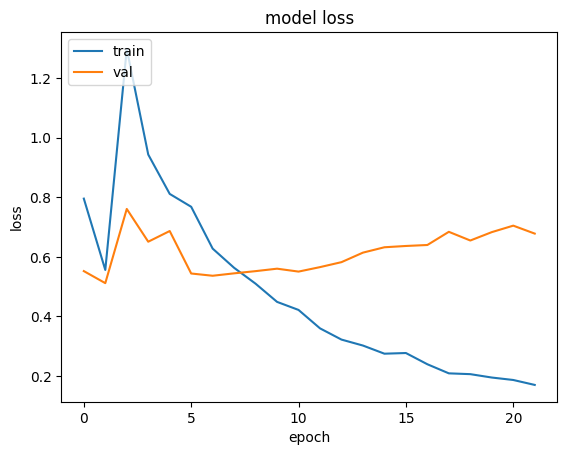

In [38]:
plt.plot(train_loss)
plt.plot(valid_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

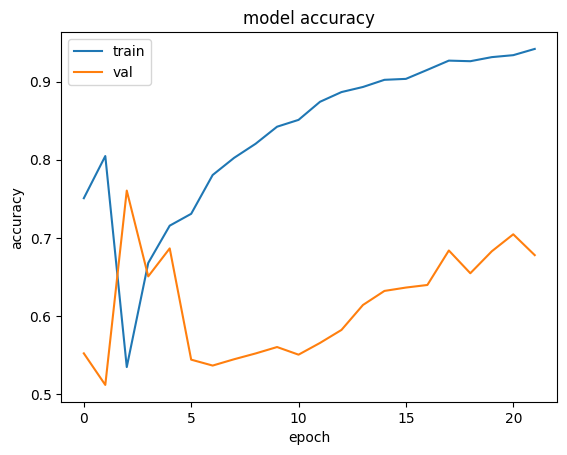

In [39]:
plt.plot(train_acc)
plt.plot(valid_loss)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [40]:
print("Validation accuracy of model after 20 epochs training: ", valid_acc[-1])

Validation accuracy of model after 20 epochs training:  0.7645333333333333


#Testing

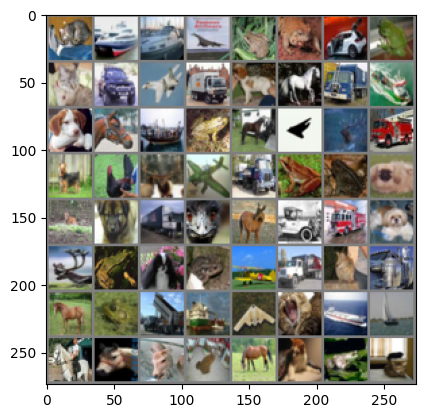

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship  dog   horse ship  frog  horse plane deer  truck dog   bird  deer  plane truck frog  frog  dog   deer  dog   truck bird  deer  car   truck dog   deer  frog  dog   frog  plane truck cat   truck horse frog  truck ship  plane cat   ship  ship  horse horse deer  frog  horse cat   frog  cat  


In [41]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(64)))

In [42]:
net = ConvNeuralNet()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [43]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(64)))

Predicted:  cat   ship  ship  plane frog  frog  truck frog  cat   car   plane truck dog   horse truck ship  dog   horse ship  frog  horse plane deer  truck deer  frog  car   plane truck frog  frog  dog   bird  cat   truck cat   dog   car   truck dog   deer  frog  horse frog  plane truck cat   dog   horse bird  plane ship  horse dog   ship  plane horse dog   bird  deer  horse dog   frog  cat  


In [78]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

acc_test = correct /total
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 74 %


Phân tích acc trên từng class:

In [45]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 77.8 %
Accuracy for class: car   is 86.8 %
Accuracy for class: bird  is 61.8 %
Accuracy for class: cat   is 54.4 %
Accuracy for class: deer  is 68.3 %
Accuracy for class: dog   is 66.2 %
Accuracy for class: frog  is 82.2 %
Accuracy for class: horse is 80.4 %
Accuracy for class: ship  is 82.3 %
Accuracy for class: truck is 83.9 %


# Hyperparameters Tuning

Hyperparameters em lựa chọn tinh chỉnh bao gồm: learning rate, batch size, drop out rate.

Phương pháp: optuna.

In [46]:
!pip install optuna
import optuna
from optuna.trial import TrialState
import torch.optim as optim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.9 MB/s eta 0:00:00


In [71]:
def train(model):
  for epoch in range(num_epochs):

    overall_loss = 0.0; correct = 0; total = 0
    model.train() # Active training mode of model, DO NOT forget this line

    for images, labels in (pbar:=tqdm(trainloader, desc=f'Epoch [{epoch+1}/{num_epochs}]')):
        # Transfer data to device (GPU/CPU)
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        overall_loss += loss.item()

        # Compute accuracy
        preds = torch.argmax(outputs.data, dim=1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

        # Progress bar logging
        pbar.set_postfix(loss=loss.item(), accuracy=correct/total)

        # Backward and optimize
        optimizer.zero_grad()   # Clear gradient cache of the previous step iteration
        loss.backward()
        optimizer.step()

In [74]:
def valid(model):
  model.eval()
  total = 0; correct = 0;

  with torch.no_grad():
    for data in validloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
  accuracy = correct / len(validloader.dataset)
  return accuracy

In [75]:
def objective(trial):

    #search_space:
    drop_fc1 = trial.suggest_float("drop_fc1", 0.2, 0.5)
    learning_rate = trial.suggest_float("learning_rate = ", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    #load data
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
    validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

    #model setting
    model = ConvNeuralNet(trial, in_channels=3, num_classes=10, drop_fc1 = drop_fc1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training of the model
    for epoch in range(num_epochs):
        train(model)  # Train the model
        accuracy = valid(model)   # Evaluate the model

        # For pruning (stops trial early if not promising)
        trial.report(accuracy, epoch)
        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [ ]:
number_of_trials = 10
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=number_of_trials)
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    # Display the study statistics
print("\nStudy statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

trial = study.best_trial
print("Best trial:")
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-11-28 15:42:18,787] A new study created in memory with name: no-name-38b68268-2f9a-436e-ad68-6b38c875fe87
Epoch [7/20]:   7%|▋         | 48/665 [00:09<01:42,  6.05it/s, accuracy=0.118, loss=2.47]

Sau khi có được bộ hyper parameters tốt nhất thì ta sẽ sử dụng nó để làm hyper paremeters cho final model, sau đó thực hiện train lại model.

# Results and Analysis

In [79]:
print("Train set accuracy of model after 20 epochs training: ", train_acc[-1])
print("Validation set accuracy of model after 20 epochs training: ", valid_acc[-1])
print("Test set accuracy of model after 20 epochs training: ", acc_test)

Train set accuracy of model after 20 epochs training:  0.942
Validation set accuracy of model after 20 epochs training:  0.7645333333333333
Test set accuracy of model after 20 epochs training:  0.7487


In [81]:
print("Train set loss of model after 20 epochs training: ", train_loss[-1])
print("Validation set loss of model after 20 epochs training: ", valid_loss[-1])

Train set loss of model after 20 epochs training:  0.1700459545268152
Validation set loss of model after 20 epochs training:  0.6778293217823004


Nhận xét kết quả:
+ Model có hiện tượng overfit, vì acc trên tập train tốt hơn nhiều so với trên tập valid và test.
+ Kết quả của model vẫn chưa đủ tốt, mức kỳ vọng đặt ra là trên 80% và chưa đạt được.



## Một số quan sát, nhận xét rút ra trong quá trình làm bài

###1. Trong quá trình cải tiến model
Đầu tiên em sử dụng model được thầy minh họa trong buổi học thực hành, sau khi đánh giá trên tập test thì nhận thấy model đang bị overfit. Em quyết định thêm một số thành phần để cải thiện vấn đề này: dropout, batchnorm.

Tuy nhiên, mô hình lại bị underfit (acc trên trainset cũng không cao), nên em đã tăng tính phức tạp của mô hình bằng một số cách: tăng chiều sâu của Network bởi các conv2d và pooling layer, hoặc tăng phi tuyến hóa bằng cách thêm activate function.

Em đã thử hơn 10 models ứng với từng thay đổi em muốn thử và rút ra được một số nhận xét như sau:
+ Thêm Droupout vào model gốc cải thiện acc của test (khoảng 2.3%) nhưng giảm acc của train đáng kể (gần 9%)
+ Thêm các hàm kích hoạt ReLU sau các Conv2d có hiệu quả lớn nhất trong các thay đổi (tăng acc test lên hơn 6%)
+ Việc thêm batch norm có cải thiện acc của test nhưng ít và cũng không gây ảnh hưởng nhiều đến acc train.
+ Thêm nhiều Conv 2d (3x3) đem lại hiệu quả không đáng kể.
+ Thử các activate function khác như: Sigmoid, Tanh, kết quả không tốt bằng ReLU.

Em đã không tăng số lớp Fully Connected lên vì không muốn model có quá nhiều tham số dẫn đến việc train lâu (do hạn chế về tài nguyên và thời gian).

Cuối cùng, em lựa chọn model có acc test tốt nhất (nhỉnh hơn 80%) và acc train khá ổn (95%).



###2. Thêm data augmentation
Việc thêm data augmentation khiến giảm acc của tập test, ban đầu em cho nhiều phép biến đổi nên bị giảm gần 10%, sau đó em sửa lại với ít phép biến đổi hơn thì cho được acc như hiện tại.

Có thể việc biến đổi nhiều đã khiến cho model khó có thể học được những đặc trưng và model của em còn khá đơn giản nên không đem lại hiệu quả cần có của kỹ thuật này.


###3. Tuning siêu tham số
Model có khá nhiều siêu tham số cần được tinh chỉnh, ngoài learning rate, batch size, drop out rate. Có thể kể đến: number_epoch, number of filters in the convolutional layers, kernel size, activate function.

Tuy nhiên do thời gian và nguồn lực hạn chế về việc tính toán, em vẫn chưa thể hoàn thành được bước tuning này.

##Bài học từ Lab1

+ Làm quen với Pytorch.
+ Thử nghiệm các thay đổi trên kiến trúc model để cải thiện kết quả và đối chiếu với kiến thức lý thuyết được học.
+ Học và thực hành data augmentation và tuning hyper parameters.
+ Quản lý thời gian: trải nghiệm một quy trình đầy đủ và ước lượng được khoảng thời gian cần dành ra cũng như thứ tự ưu tiên thực hiện của các bước để có thể làm tốt và hiệu quả hơn ở lần sau.
+ Nên thử fine tune model xem kẽ với việc cải tiến kiến trúc model, lần này em để fine tune lại cuối cùng và thấy chưa hiệu quả.
